# C3 Project 1: Image Classification

In [2]:
from main import test, train, TrainDataset, TestDataset
from bovw import BOVW
# metrics 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from typing import List, Dict, Tuple    

import pandas as pd

## Charge the data

In [9]:
data_train = TrainDataset()
data_test = TestDataset()

### Experiment 1

In [10]:
# HYPERPARAMETERS
detector_type = "DenseSIFT"
codebook_size = 256
classifier_algorithm = "LogisticRegression"
detector_kwargs = {}
stride=8
scale=2

# Compute cache paths
kwarg_detector_str = [f"_{str(key)}-{str(value)}" for key, value in detector_kwargs.items()]
kwarg_detector_str = "".join(kwarg_detector_str)
cache_file_train = "./cache_train/"+detector_type+"_stride-8_scale-2.pkl"
cache_file_test = "./cache_test/"+detector_type+"_stride-8_scale-2.pkl"

print(cache_file_test)

./cache_test/DenseSIFT_stride-8_scale-2.pkl


## Run experiment

In [11]:
bovw = BOVW(detector_type=detector_type, codebook_size=codebook_size, detector_kwargs=detector_kwargs, stride=stride, scale=scale, normalize=True)

if classifier_algorithm == 'LogisticRegression':
        classifier = LogisticRegression(class_weight="balanced", C=1000, max_iter=500)
elif classifier_algorithm == 'SVM':
        classifier = SVC(class_weight="balanced", probability=True, random_state=42, C=100)

# TRAIN
y_pred_train, y_probas_train, labels_train, _ = train(dataset=data_train, bovw=bovw, classifier=classifier, cache_file=cache_file_train)
train_acc = accuracy_score(y_true=labels_train, y_pred=y_pred_train)
print("Accuracy on Phase[Train]:", train_acc)

# TEST
y_pred_test, y_probas_test, labels_test = test(dataset=data_test, bovw=bovw, classifier=classifier, cache_file=cache_file_test)
test_acc = accuracy_score(y_true=labels_test, y_pred=y_pred_test)
print("Accuracy on Phase[Test]:", test_acc)

Phase[Train]: Loading descriptors from ./cache_train/DenseSIFT_stride-8_scale-2.pkl
Fitting the codebook (took 29.62 seconds)
Computing the bovw histograms
Fitting the classifier (cross-validation)
Classifier fitted.
Accuracy on Phase[Train]: 0.3139080459770115
Phase[Test]: Loading descriptors from ./cache_test/DenseSIFT_stride-8_scale-2.pkl
Computing the bovw histograms
Predicting the values
Accuracy on Phase[Test]: 0.33181818181818185


# LOCAL DESCRIPTORS EXPERIMENT

### Search which local descriptor is the best for our image classification task

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

### The metrics have been computed using the sweep_launcher.py, which stores the results in wandb

In [17]:
# --- MANUALLY ENTERED DATA ---
# Format: {'Descriptor': [Accuracy, F1 Score, Precision, Recall] }
performance_data = {
    #'ORB': [17.4, 16.8, 16.8, 17.4],
    'ORB': [18.7, 18.0, 18.2, 18.6],
    'AKAZE': [18.6, 17.7, 17.8, 18.6],
    #'SIFT': [31.2, 30.1, 30.0, 31.0],
    'SIFT': [30.6, 29.6, 29.5, 30.4],
    'Dense SIFT': [31.8, 30.5, 30.7, 31.6]
}

# Format: {'Descriptor': [ [acc_folds], [f1_folds], [prec_folds], [rec_folds] ] }
performance_data_folds = {
    'ORB': [
        [18.9, 20.0, 19.0, 17.1, 18.7],
        [18.2, 18.8, 18.3, 16.1, 18.3],
        [18.5, 19.0, 18.7, 16.1, 18.6],
        [18.8, 19.6, 18.9, 17.0, 18.7] 
    ],
    #'ORB': [
    #    [17.1, 18.0, 18.0, 17.1, 16.9],
    #    [16.3, 17.5, 17.5, 16.5, 16.4],
    #    [16.3, 17.4, 17.7, 16.4, 16.5],
    #    [17.0, 18.0, 18.0, 17.1, 16.8] 
    #],
    'AKAZE': [
        [19.5, 18.2, 18.1, 18.1, 19.0],
        [18.6, 17.1, 17.4, 17.2, 18.2],
        [18.7, 17.2, 17.7, 17.4, 18.5],
        [19.4, 18.2, 18.1, 18.1, 19.0]        
    ],
    #'SIFT': [
    #    [33.2, 31.4, 30.5, 31.0, 30.2],  # Accuracy
    #    [31.9, 30.4, 29.4, 29.4, 29.1],  # F1
    #    [31.9, 30.6, 29.5, 29.0, 29.0],  # Precision
    #    [32.9, 31.3, 30.3, 30.7, 30.0]   # Recall
    #],
    'SIFT':[
        [33.2, 28.2, 30.8, 30.3, 30.6],
        [31.9, 27.2, 29.8, 29.2, 29.5],
        [31.8, 27.4, 30.0, 29.2, 29.4],
        [32.9, 28.1, 30.6, 30.2, 30.4]
    ],
    'Dense SIFT':[
        [31.2, 31.1, 32.6, 31.0, 33.0],
        [29.8, 29.6, 31.2, 29.8, 31.9],
        [30.2, 29.7, 31.3, 30.1, 32.2],
        [31.0, 30.9, 32.4, 30.8, 32.9]
    ]
}

performance_data_nfeatures = {
    'SIFT':{
        16: [16.9, 18.0, 17.7, 17.4, 16.4],
        50:[23.4, 20.1, 21.7, 21.4, 21.3],
        100:[24.0, 23.6, 23.9, 22.5, 23.2],
        500:[31.9, 28.5, 28.3, 27.8, 28.5],
        1024:[33.2, 28.2, 30.8, 30.3, 30.6],
        #2000:[33.1, 31.4, 30.5, 31.0, 30.2]
    },
    'Dense SIFT':{
        16:[18.0, 17.9, 18.0, 19.3, 17.2],
        64:[25.1, 23.8, 23.4, 23.9, 25.3],
        256:[30.7, 28.2, 30.9, 28.7, 29.5],
        1024:[31.2, 31.1, 32.6, 31.0, 33.0],
        
    }
}

## Plot functions

In [10]:
def plot_performance_metrics(data, title="Average metrics on cross-validation", x_axis_title='Descriptors'):
    """
    Generates a grouped bar chart to compare performance metrics of different 
    local descriptors, replicating the format of the provided image.

    Args:
        data (dict): Dictionary where keys are the descriptor names 
                     and values are lists of the 4 metrics (Accuracy, F1 Score, 
                     Precision, Recall) in order.
        title (str): Title of the chart.
    """
    
    # 1. Data and Label Preparation
    # The order of the metrics must be: Accuracy, F1 Score, Precision, Recall
    metrics_names = ['Accuracy', 'F1', 'Precision', 'Recall']
    descriptors = list(data.keys())
    
    # Defined colors to replicate the chart (approximated)
    colors = ['gold', 'salmon', 'skyblue', 'lightgreen']
    
    # Extract the metric values for each descriptor
    # `values` will be a list of lists: [[AKAZE_acc, AKAZE_f1, ...], [ORB_acc, ...], ...]
    values = list(data.values())
    
    # Convert to a NumPy array for easy transposition
    data_array = np.array(values)
    
    # 2. Chart Configuration
    
    # Number of descriptors (bar groups)
    n_descriptors = len(descriptors)
    # Number of metrics per descriptor (bars per group)
    n_metrics = len(metrics_names) 
    
    # Width of each bar
    bar_width = 0.20
    
    # Base positions on the X-axis for each descriptor group
    # Generates a set of indices for each group: [0, 1, 2, 3]
    index = np.arange(n_descriptors) 
    
    # 3. Create the figure and axes
    
    fig, ax = plt.subplots(figsize=(12, 6)) # Figure size
    
    # 4. Draw the Grouped Bars
    
    # Iterate over each metric (4 times) to draw its bars across all descriptors
    for i in range(n_metrics):
        # Calculate the adjusted X position for metric i
        # Example for i=0 (Accuracy): index - 1.5*bar_width
        # Example for i=1 (F1 Score): index - 0.5*bar_width
        # ...
        bar_pos = index + (i - (n_metrics / 2) + 0.5) * bar_width
        
        # Get the values of metric i for all descriptors
        metric_values = data_array[:, i] 
        
        rects = ax.bar(bar_pos, 
                       metric_values, 
                       bar_width, 
                       color=colors[i],
                       label=metrics_names[i])
        
        # 5. Add Value Labels (the numbers on top of the bars)
        for rect in rects:
            height = rect.get_height()
            # Format the value to one decimal place and place it above the bar
            ax.text(rect.get_x() + rect.get_width() / 2., 
                    height + 0.5, # Vertical offset of 0.5
                    f'{height:.1f}', 
                    ha='center', 
                    va='bottom',
                    fontsize=9)

    # 6. Customize Axes and Title
    
    # Main title
    ax.set_title(title, fontsize=16, pad=20)
    
    # Y-axis labels
    ax.set_ylabel('Score (%)', fontsize=12)
    ax.set_ylim(0, 40)
    
    # X-axis labels (Descriptor Names)
    ax.set_xticks(index)
    ax.set_xticklabels(descriptors, fontsize=11)
    ax.set_xlabel(x_axis_title, fontsize=12)
    
    # Add the legend with the title "Metrics"
    ax.legend(title="Metrics", loc='upper left')
    
    # Add subtle horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.2)
    
    # Hide top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout() # Adjust layout
    plt.show()

In [4]:
def plot_performance_boxplots(data, title="Comparison of local descriptors (cross-validation)", dim = [10,40], x_axis_title="Descriptors"):
    """
    Generates a grouped boxplot chart to compare performance metrics of different 
    local descriptors across multiple folds.

    Args:
        data (dict): Dictionary where keys are the descriptor names.
                     Values are lists of lists:
                     [ [acc_fold1, acc_fold2...], [f1_fold1...], [prec...], [rec...] ]
                     The order must be: Accuracy, F1, Precision, Recall.
        title (str): Title of the chart.
    """
    
    # 1. Data and Label Preparation
    metrics_names = ['Accuracy', 'F1', 'Precision', 'Recall']
    descriptors = list(data.keys())
    metrics_colors = ['gold', 'salmon', 'skyblue', 'lightgreen']
    
    # 2. Chart Configuration
    n_descriptors = len(descriptors)
    n_metrics = len(metrics_names)
    
    # Width of individual box
    box_width = 0.15
    # Base positions for groups
    index = np.arange(n_descriptors)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 3. Draw the Grouped Boxplots
    # We iterate by metric to plot all descriptors for that metric at once.
    # This makes handling positions easier.
    
    for i in range(n_metrics):
        # Extract the data for this specific metric across all descriptors
        # metric_data will be a list of lists (one list of folds per descriptor)
        metric_data = [data[desc][i] for desc in descriptors]
        
        # Calculate positions: center around the descriptor index
        positions = index + (i - (n_metrics / 2) + 0.5) * 0.2
        
        # Create the boxplot
        bp = ax.boxplot(metric_data, 
                        positions=positions, 
                        widths=box_width, 
                        patch_artist=True,
                        showfliers=True, # Show outliers
                        boxprops=dict(facecolor=metrics_colors[i], color='black', alpha=0.9),
                        capprops=dict(color='black'),
                        whiskerprops=dict(color='black'),
                        medianprops=dict(color='black', linewidth=1.5),
                        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3))

    # 4. Customize Axes and Title
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_ylabel('Score (%)', fontsize=12)
    
    # Adjust Y-limits to fit data + margin (e.g., 0 to 50 or dynamic)
    # You might want to change this to ax.set_ylim(0, 100) if scores are high
    ax.set_ylim(dim[0], dim[1]) 
    
    # X-axis formatting
    ax.set_xticks(index)
    ax.set_xticklabels(descriptors, fontsize=12)
    ax.set_xlabel(x_axis_title, fontsize=12)
    
    # 5. Custom Legend
    # Since boxplots don't add labels to legend automatically in a loop well,
    # we create manual proxy artists.
    legend_patches = []
    for i, name in enumerate(metrics_names):
        patch = mpatches.Patch(color=metrics_colors[i], label=name)
        legend_patches.append(patch)
        
    ax.legend(handles=legend_patches, title="Metrics", loc='upper left')
    
    # Grid and Spines
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [12]:
def plot_accuracy_curve(data_dict, title="Impact of nFeatures on Accuracy", labels = ["Number of Features (nFeatures)", "Mean Accuracy (%)"], dim = [10,40]):
    """
    Plots Accuracy vs. nFeatures using lines for the mean and 
    shaded bands for the standard deviation across folds.
    
    Args:
        data_dict (dict): Dictionary with the format:
                          {
                              'DescriptorName': {
                                  n_feat_val1: [acc_fold1, acc_fold2, ...],
                                  n_feat_val2: [...],
                                  ...
                              },
                              ...
                          }
        title (str): Chart title.
    """
    
    # Style configuration for a clean, professional look
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define specific colors and markers for differentiation
    styles = {
        'Dense SIFT': {'color': '#1f77b4', 'marker': 'o', 'label': 'Dense SIFT'}, # Professional Blue
        'SIFT':       {'color': '#d62728', 'marker': 's', 'label': 'SIFT'} # Brick Red
    }
    
    # Iterate only over the desired descriptors
    for desc_name in data_dict:
            
        desc_data = data_dict[desc_name]
        
        # 1. Prepare Data: Extract and sort by n_features (X-axis)
        # Sorting is crucial for the line to be drawn correctly
        sorted_nfeats = sorted(desc_data.keys())
        
        means = []
        stds = []
        
        # 2. Calculate Statistics (Mean and Standard Deviation) for each point
        for nfeat in sorted_nfeats:
            folds_accs = np.array(desc_data[nfeat])
            means.append(np.mean(folds_accs))
            stds.append(np.std(folds_accs))
            
        means = np.array(means)
        stds = np.array(stds)
        x_vals = np.array(sorted_nfeats)
        
        # Get style or default
        style = styles.get(desc_name, {'color': 'green', 'marker': 'p', 'label': desc_name})
        
        # 3. Plot the MEAN Line
        ax.plot(x_vals, means, 
                color=style['color'], 
                marker=style['marker'], 
                markersize=8, 
                linewidth=2.5, 
                label=style['label'],
                zorder=3) # High zorder to stay on top of the shadow
        
        # 4. Plot the SHADED BAND (Mean ± 1 Standard Deviation)
        # This visually represents variance without using boxplots
        ax.fill_between(x_vals, 
                        means - stds, # Lower bound
                        means + stds, # Upper bound
                        color=style['color'], 
                        alpha=0.2, # Transparency to see grid lines
                        zorder=2)

    # --- Axes and Legend Configuration ---
    
    # X-Axis: Logarithmic scale due to the nature of n_features (50, 100, 1000...)
    ax.set_xscale('log')
    
    # Manually define X-ticks to match the tested values
    all_nfeats = set()
    for desc in data_dict:
        all_nfeats.update(data_dict[desc].keys())
            
    sorted_ticks = sorted(list(all_nfeats))
    ax.set_xticks(sorted_ticks)
    ax.set_xticklabels(sorted_ticks, fontsize=10)
    ax.set_xlabel(labels[0], fontsize=12, labelpad=10)

    # Y-Axis
    ax.set_ylabel(labels[1], fontsize=12, labelpad=10)
    
    # Adjust these limits based on your real data range (e.g., 0.2 to 0.9)
    ax.set_ylim(dim[0], dim[1]) 
    
    # Title and Legend
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Clean legend
    legend = ax.legend(frameon=True, fancybox=True, framealpha=0.9, shadow=True, loc='lower right')
    legend.get_frame().set_facecolor('white')

    # Final adjustments
    ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Remove top and right spines for a cleaner scientific look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [3]:
def plot_spatial_pyramids_boxplots(data, title="Spatial Pyramid Matching Performance", x_text="Level", x_axis_label = 'Pyramid Level ($L$)', y_axis_label_1 = 'Accuracy (%)', y_axis_label_2='Run Time (minutes)', y_dim = [25, 45], bp_width=0.3):
    """
    Plots Accuracy using Boxplots (left axis) and Runtime using a Line plot (right axis).
    
    Args:
        data (dict): Dictionary containing 'Spatial pyramid levels' with 'Accuracy' 
                     and 'Runtime' sub-dictionaries.
        title (str): Chart title.
    """
    
    # 1. Data Extraction
    sp_data = data['Data']
    
    # Get sorted levels (0, 1, 2...)
    levels = sorted(sp_data['Accuracy'].keys())
    
    # Extract Accuracy data as a list of lists for the boxplot
    # format: [[acc_level0_fold1, ...], [acc_level1_fold1, ...], ...]
    accuracy_data = [sp_data['Accuracy'][l] for l in levels]
    
    # Extract Runtime data
    runtimes = [sp_data['Runtime'][l] for l in levels]
    
    # 2. Setup Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # --- LEFT Y-AXIS: ACCURACY (BOXPLOTS) ---
    color_acc = '#1f77b4' # Professional Blue
    
    # Draw Boxplots
    # positions=levels ensures they are placed at 0, 1, 2 on x-axis
    bp = ax1.boxplot(accuracy_data, 
                     positions=levels, 
                     widths=bp_width, 
                     patch_artist=True,
                     boxprops=dict(facecolor=color_acc, color='black', alpha=0.6),
                     capprops=dict(color='black'),
                     whiskerprops=dict(color='black'),
                     medianprops=dict(color='black', linewidth=1.5),
                     flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # Axis Formatting
    ax1.set_xlabel(x_axis_label, fontsize=12, labelpad=10)
    ax1.set_ylabel(y_axis_label_1, fontsize=12, color=color_acc, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color_acc)
    
    # Set the specific limits you requested
    ax1.set_ylim(y_dim[0], y_dim[1])
    
    # Ensure X-axis shows integer levels
    ax1.set_xticks(levels)
    ax1.set_xticklabels([f"{x_text} {l}" for l in levels])
    
    # --- RIGHT Y-AXIS: RUNTIME (LINE) ---
    ax2 = ax1.twinx()
    color_time = '#d62728' # Professional Red
    
    # Plot Time Line
    # We plot this *over* the boxplots
    line2, = ax2.plot(levels, runtimes, marker='s', linestyle='--', 
                      linewidth=2, color=color_time, label='Run Time')
    
    # Axis Formatting for Time
    ax2.set_ylabel(y_axis_label_2, fontsize=12, color=color_time, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color_time)
    
    # --- LEGEND & STYLING ---
    # Create a custom proxy artist for the boxplot to show in legend
    import matplotlib.patches as mpatches
    patch_acc = mpatches.Patch(color=color_acc, label='Accuracy Distribution')
    
    # Combine legends
    lines = [patch_acc, line2]
    labels = [l.get_label() for l in lines]
    
    ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax1.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Clean up appearance
    ax1.grid(True, linestyle='--', alpha=0.6, axis='y') # Grid only on Y axis often looks cleaner with boxplots
    ax1.spines['top'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

### Plot all the graphs with the given data

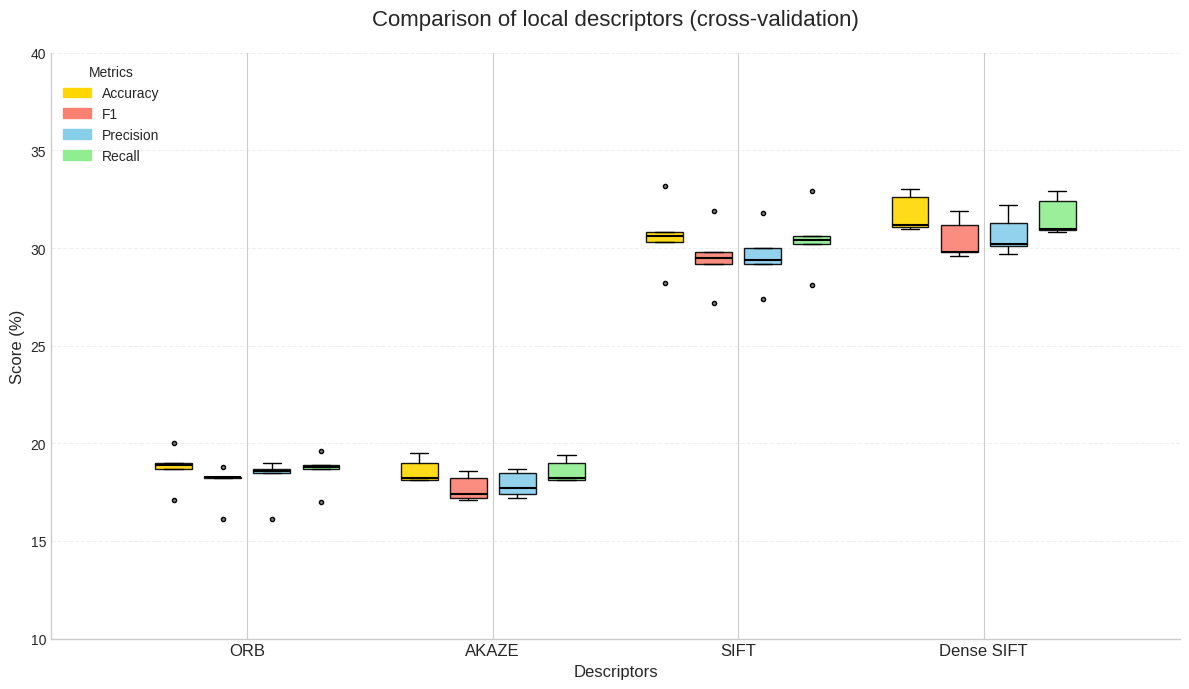

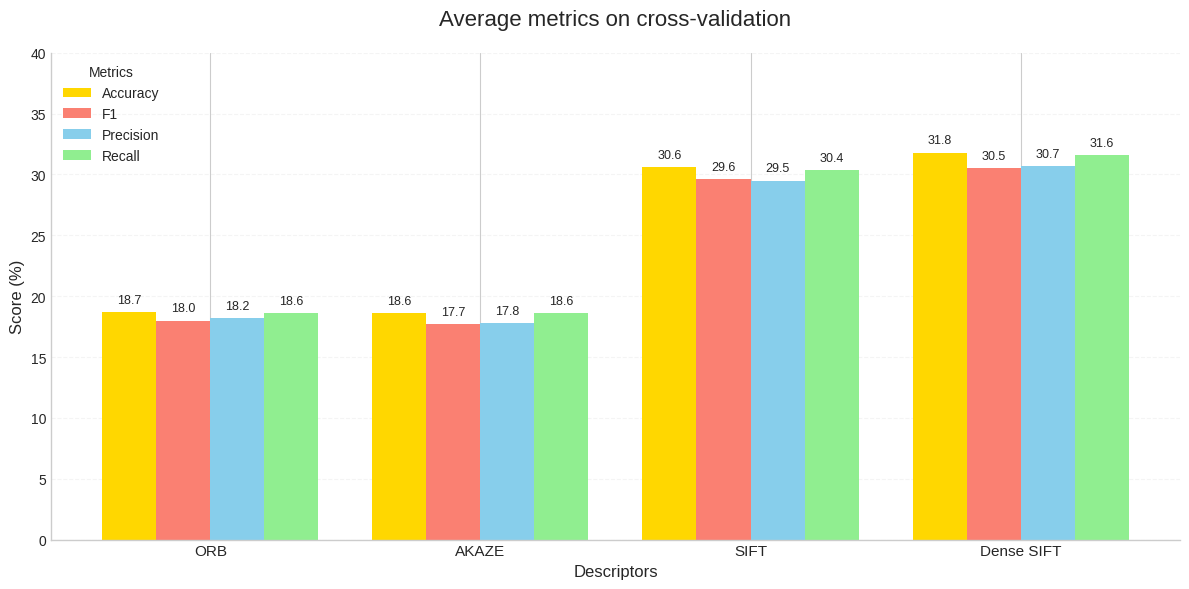

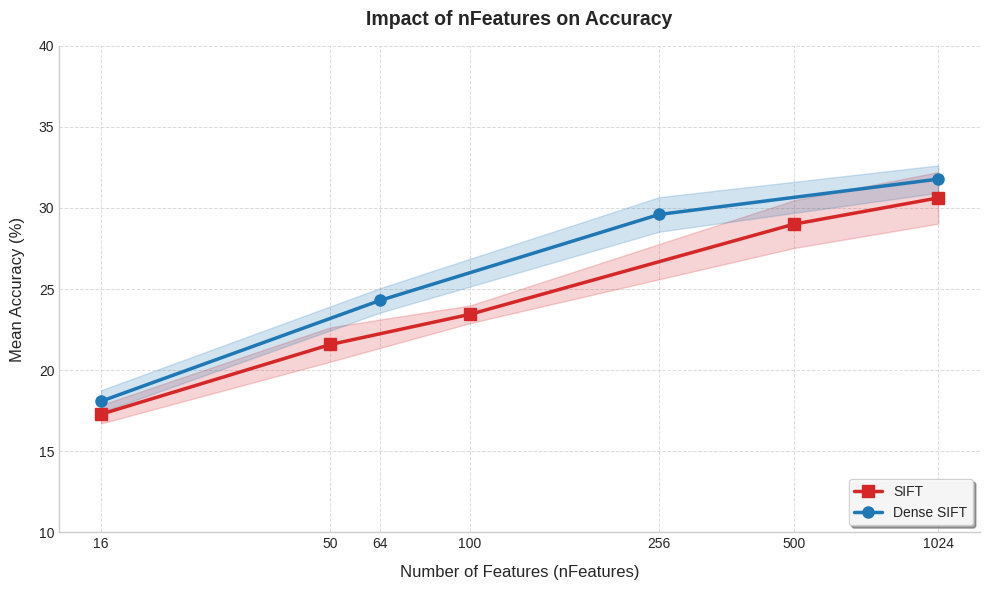

In [18]:
plot_performance_boxplots(performance_data_folds)

plot_performance_metrics(performance_data)

plot_accuracy_curve(performance_data_nfeatures)


# CODEBOOK SIZE EXPERIMENT

In [8]:
folds_accs = [[0.15747126436781608, 0.15862068965517245, 0.16206896551724137, 0.15459770114942528, 0.15747126436781608], 
              [0.21264367816091953, 0.21379310344827587, 0.23908045977011497, 0.2149425287356322, 0.22413793103448276], 
              [0.27873563218390807, 0.29022988505747127, 0.27413793103448275, 0.28160919540229884, 0.2620689655172414], 
              [0.3017241379310345, 0.3028735632183908, 0.3005747126436782, 0.3040229885057471, 0.28793103448275864], 
              [0.31494252873563217, 0.32126436781609197, 0.3086206896551724, 0.32298850574712645, 0.29942528735632185], 
              [0.31666666666666665, 0.33793103448275863, 0.32298850574712645, 0.3431034482758621, 0.3218390804597701], 
              [0.3258620689655172, 0.34655172413793106, 0.3367816091954023, 0.335632183908046, 0.3350574712643678], 
              [0.3408045977011494, 0.35919540229885055, 0.3258620689655172, 0.35, 0.33620689655172414], 
              [0.3431034482758621, 0.3471264367816092, 0.32988505747126434, 0.3545977011494253, 0.35172413793103446], 
              [0.3385057471264368, 0.3620689655172414, 0.3425287356321839, 0.34597701149425286, 0.3488505747126437]]
performance_per_codebook_size = {k:v for k,v in zip([2 ** i for i in range(2, 12)], folds_accs)}

runtime = [20, 24, 13, 14, 17, 26, 28, 34, 62, 126]

## Plot all the graphs with the given data

In [12]:
def plot_codebook_size_analysis(data: Dict[int, List[float]], runtimes: List[int], optimal_k: int):
    """
    Generates a dual-axis plot showing Mean Accuracy and Run Time vs. Codebook Size.

    Args:
        data (dict): Dictionary where keys are codebook sizes (K) and values are 
                     lists of cross-validation accuracies (used for Left Axis).
        runtimes (list): List of runtimes corresponding to the sorted K values (used for Right Axis).
        optimal_k (int): The Codebook Size (K) value to highlight.
    """
    if not data:
        print("Input data is empty. Cannot generate plot.")
        return

    # 1. Prepare Data
    # Convert keys to int for reliable sorting and access
    int_data = {int(k): v for k, v in data.items()}
    k_vals = sorted(int_data.keys())
    
    # Calculate means and stds for accuracy (Left Axis)
    means = []
    stds = []
    for k in k_vals:
        folds_accs = np.array(int_data[k])
        means.append(np.mean(folds_accs) * 100) # Convert to percentage
        stds.append(np.std(folds_accs) * 100) # Convert to percentage
        
    means = np.array(means)
    stds = np.array(stds)
    x_vals = np.array(k_vals)
    runtimes = np.array(runtimes)

    # 2. Setup Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # --- LEFT Y-AXIS: ACCURACY (MEAN +/- STD) ---
    color_acc = '#1f77b4'
    
    # Plot the MEAN Line
    ax1.plot(x_vals, means, color=color_acc, marker='o', markersize=8, linewidth=2.5, label='Mean Accuracy', zorder=3)
    
    # Plot the SHADED BAND (Mean ± 1 Standard Deviation)
    ax1.fill_between(x_vals, 
                    means - stds, 
                    means + stds, 
                    color=color_acc, alpha=0.2, label='Std Dev Band', zorder=2)

    ax1.tick_params(axis='y', labelcolor=color_acc)
    
    # Set log scale for x-axis
    ax1.set_xscale('log', base=2)
    ax1.set_xticks(x_vals)
    ax1.set_xticklabels([str(int(k)) for k in x_vals], fontsize=10)
    
    
    # Highlight the optimal K
    if optimal_k in x_vals:
        ax1.axvline(x=optimal_k, color='green', linestyle=':', linewidth=2, alpha=0.9, label=f'Optimal $K={optimal_k}$', zorder=1)

    # --- RIGHT Y-AXIS: RUNTIME (LINE) ---
    ax2 = ax1.twinx()
    color_time = '#d62728'
    
    # Plot Time Line
    ax2.plot(x_vals, runtimes, marker='s', linestyle='--', linewidth=2, color=color_time, label='Run Time (seconds)', zorder=4)
    
    # Axis Formatting for Time
    ax2.set_ylabel('Run Time (seconds)', fontsize=12, color=color_time, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color_time)
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True, fancybox=True, shadow=True, title="Metrics")
    
    ax1.set_title('Impact of Codebook Size ($K$) in Accuracy and Run Time', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

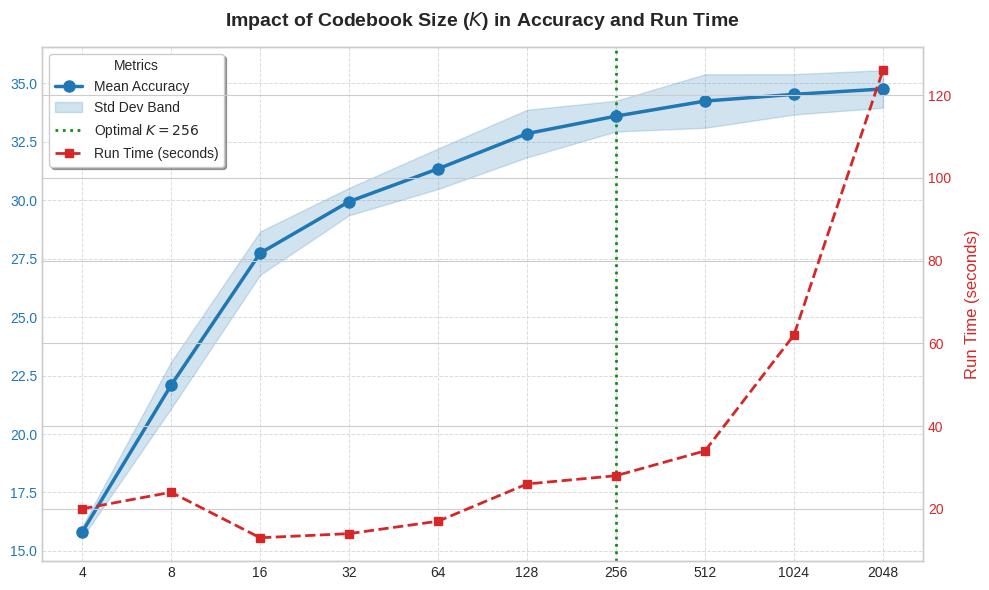

In [13]:
plot_codebook_size_analysis(performance_per_codebook_size, runtime, optimal_k=256)

# CLASSIFIERS EXPERIMENT

### Metrics

In [14]:
performance_classifier_C = {
    'Logistic Regression':{
        0.1: [24.7, 26.4, 24.5, 24.1, 24.2],
        1:[34.2, 32.3, 35.0, 32.4, 33.7],
        10:[32.7, 32.7, 33.4, 29.8, 32.9],
        100:[31.7, 31.4, 32.4, 29.2, 32.0],
        1000:[31.4, 31.5, 32.5, 29.1, 32.5],
    }
}

performance_classifier_svm = {
    'RBF':[
        [35.6, 34.8, 35.7, 33.9, 36.0],
        [34.5, 33.7, 34.9, 33.0, 35.2],
        [34.5, 33.9, 34.9, 33.3, 35.0],
        [35.3, 34.6, 35.6, 33.7, 35.8]
    ],
    'Histogram Intersection':[
        [30.9, 31.3, 32.5, 30.8, 32.6],
        [30.3, 30.7, 31.9, 30.3, 32.1],
        [30.2, 30.6, 31.8, 30.4, 32.2],
        [30.7, 31.1, 32.3, 30.6, 32.4]
    ],
    'Linear':[
        [34.8, 33.5, 34.3, 33.6, 34.8],
        [33.5, 32.0, 33.1, 32.3, 33.8],
        [33.6, 32.4, 33.2, 33.0, 33.9],
        [34.5, 33.3, 34.1, 33.4, 34.5]
    ]
}

## Plot all the graphs with the given data

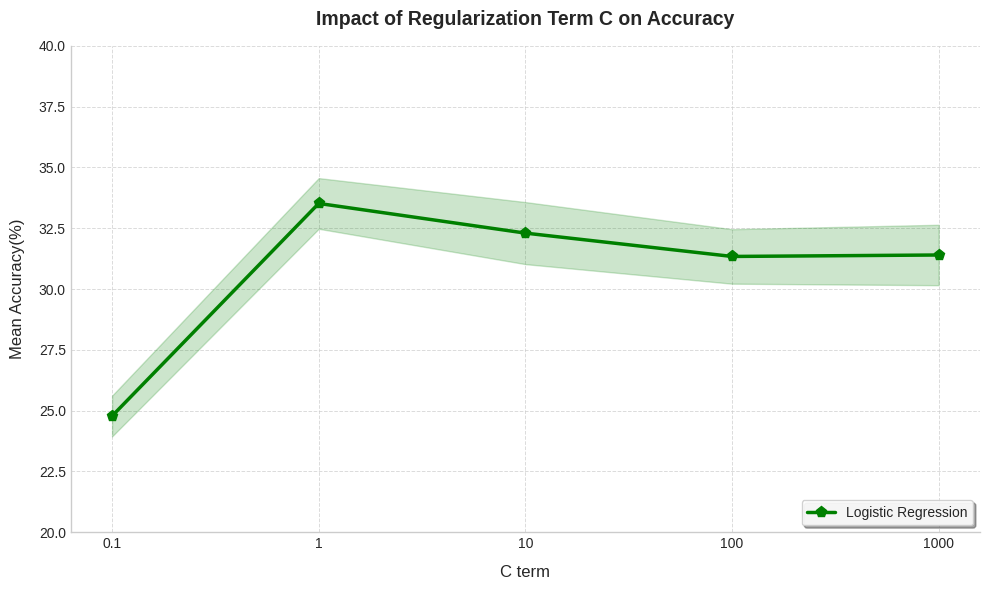

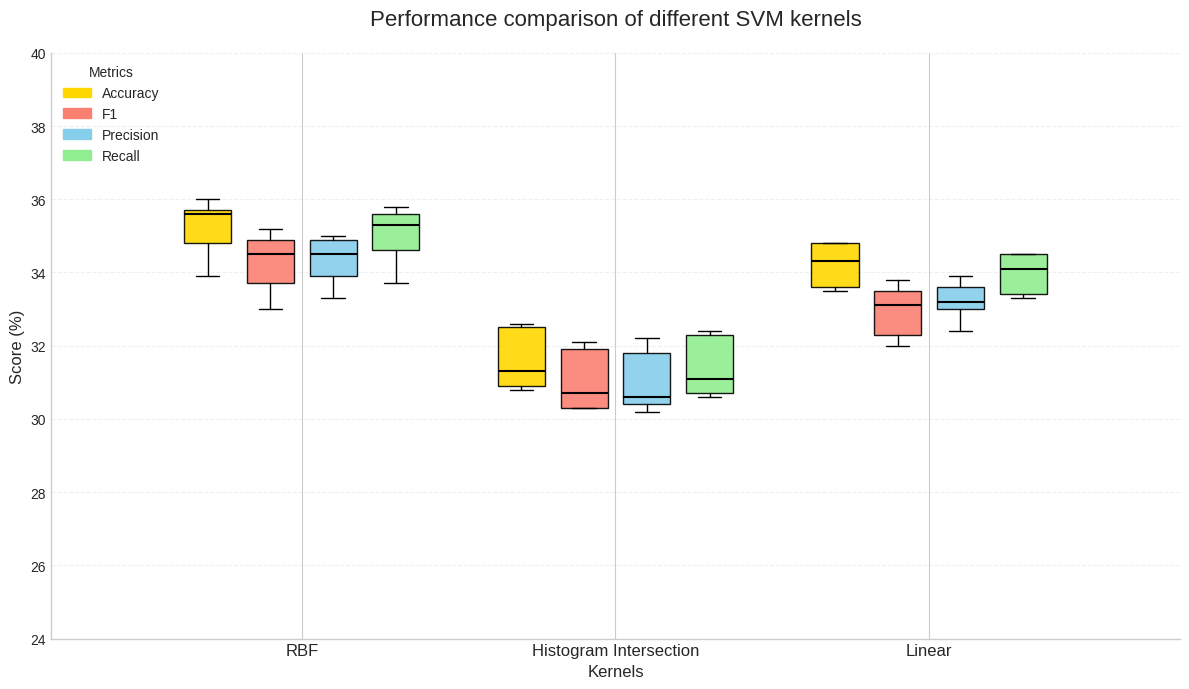

In [15]:
plot_accuracy_curve(data_dict=performance_classifier_C, 
                                  title = "Impact of Regularization Term C on Accuracy", 
                                  labels = ["C term", "Mean Accuracy(%)"],
                                  dim=[20,40])

plot_performance_boxplots(data=performance_classifier_svm, 
                          title="Performance comparison of different SVM kernels", 
                          dim=[24,40], 
                          x_axis_title="Kernels")

# SPATIAL PYRAMIDS EXPERIMENT

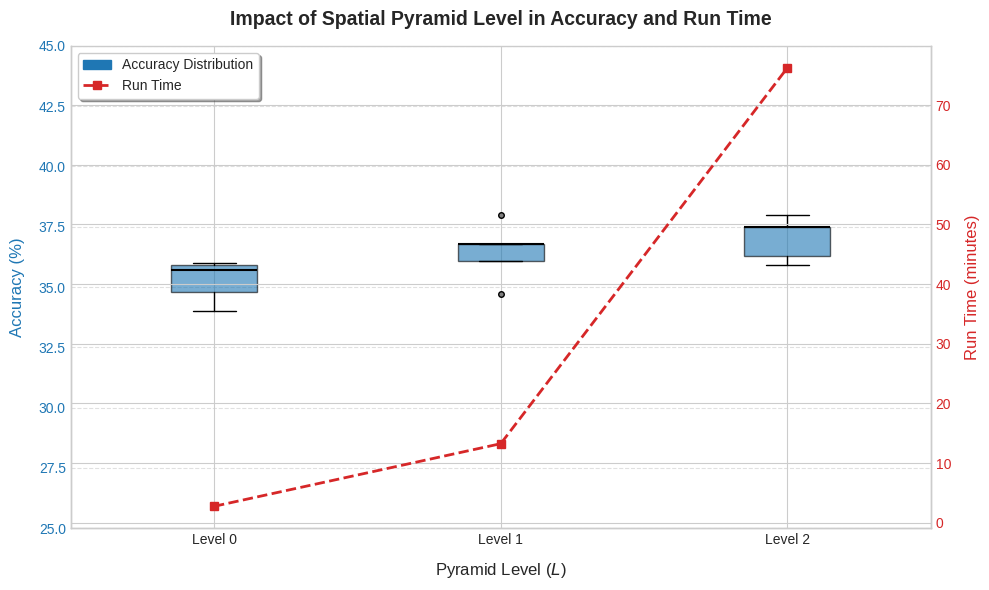

In [ ]:
performance_spatial_pyramids = {
    'Data':{
        'Accuracy':{
            0: [35.7, 34.8, 35.9, 34.0, 36.0],
            1:[38.0, 36.1, 36.8, 34.7, 36.8],
            2:[37.5, 36.3, 37.5, 35.9, 38.0]
        },
        'Runtime':{
            0: 2.75,
            1: 13.25,
            2: 76.25
        }
    }
}

plot_spatial_pyramids_boxplots(performance_spatial_pyramids, title="Impact of Spatial Pyramid Level in Accuracy and Run Time")

# PCA EXPERIMENT

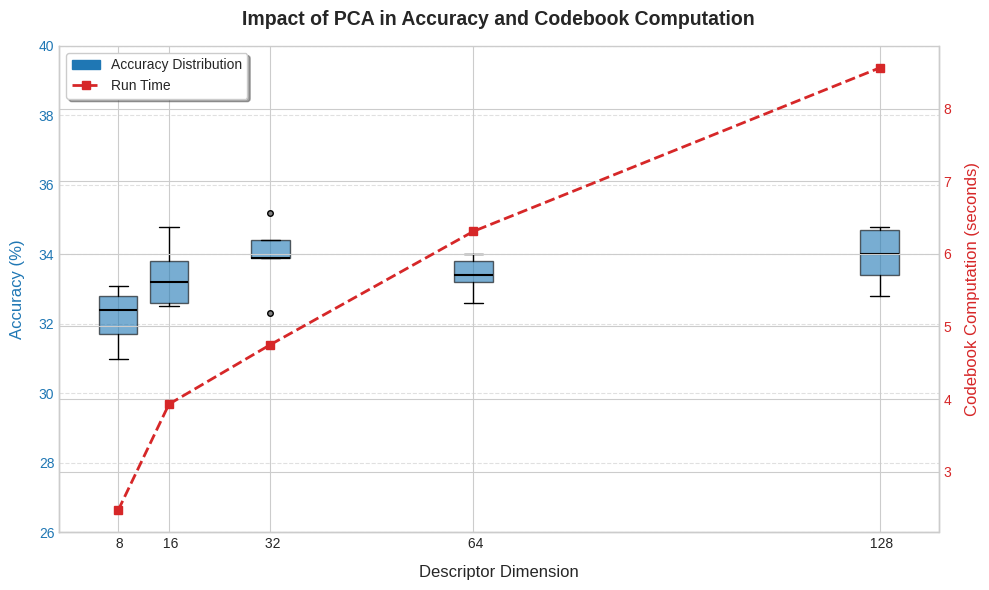

In [40]:
performance_pca = {
    'Data':{
        'Accuracy':{
            8: [32.4, 31.7, 32.8, 31.0, 33.1],
            16: [33.8, 32.6, 33.2, 32.5, 34.8],
            32: [34.4, 32.3, 33.9, 33.9, 35.2],
            64: [33.4, 33.8, 32.6, 33.2, 34.0],
            128: [34.8, 33.4, 34.7, 32.8, 34.0],
        },
        'Runtime':{
            8: 2.47,
            16: 3.93,
            32: 4.75,
            64: 6.31,
            128: 8.56,
        }
    }
}

plot_spatial_pyramids_boxplots(data=performance_pca, title="Impact of PCA in Accuracy and Codebook Computation", 
                               x_text="", x_axis_label="Descriptor Dimension", y_axis_label_2="Codebook Computation (seconds)",
                               bp_width=6, y_dim=[26,40])

# HISTOGRAM NORMALIZATION EXPERIMENT

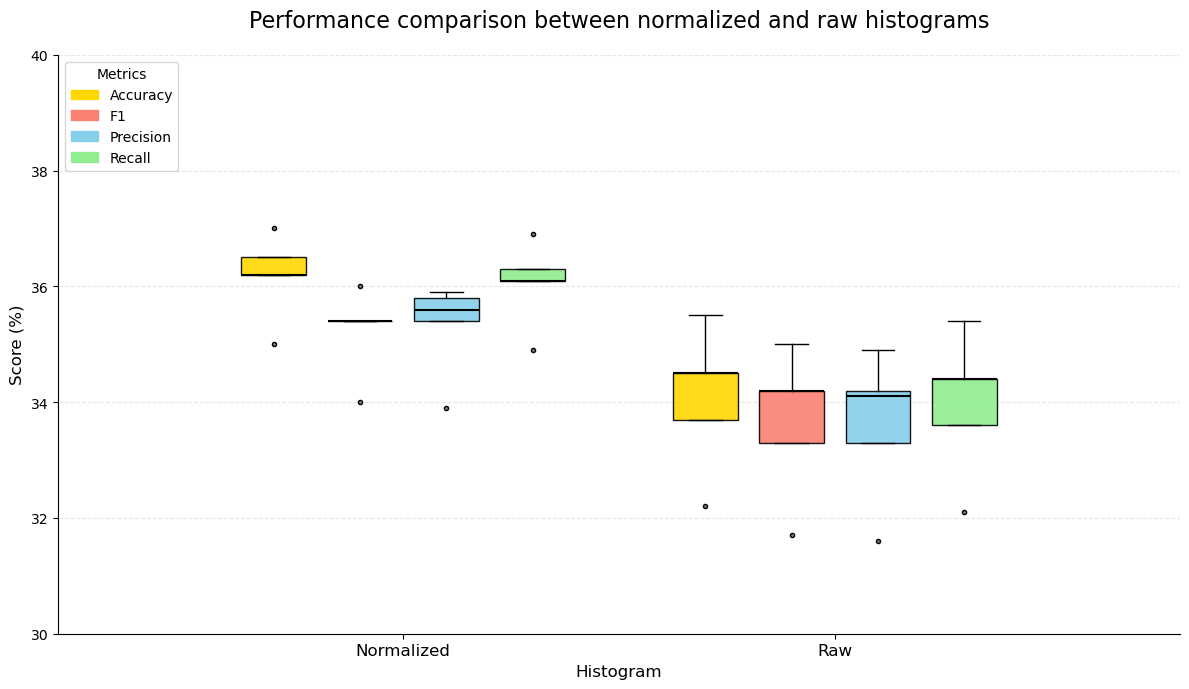

In [7]:
performance_hist_norm = {
    'Normalized':[
        [36.2, 36.5, 35.0, 36.2, 37.0],
        [35.4, 35.4, 34.0, 35.4, 36.0],
        [35.6, 35.4, 33.9, 35.8, 35.9],
        [36.1, 36.3, 34.9, 36.1, 36.9]
    ],
    'Raw':[
        [33.7, 35.5, 32.2, 34.5, 34.5],
        [33.3, 35.0, 31.7, 34.2, 34.2], 
        [33.3, 34.9, 31.6, 34.2, 34.1],
        [33.6, 35.4, 32.1, 34.4, 34.4]
    ]
}

plot_performance_boxplots(data=performance_hist_norm, 
                          title="Performance comparison between normalized and raw histograms", 
                          dim=[30,40], 
                          x_axis_title="Histogram")

# STANDARD SCALER EXPERIMENT

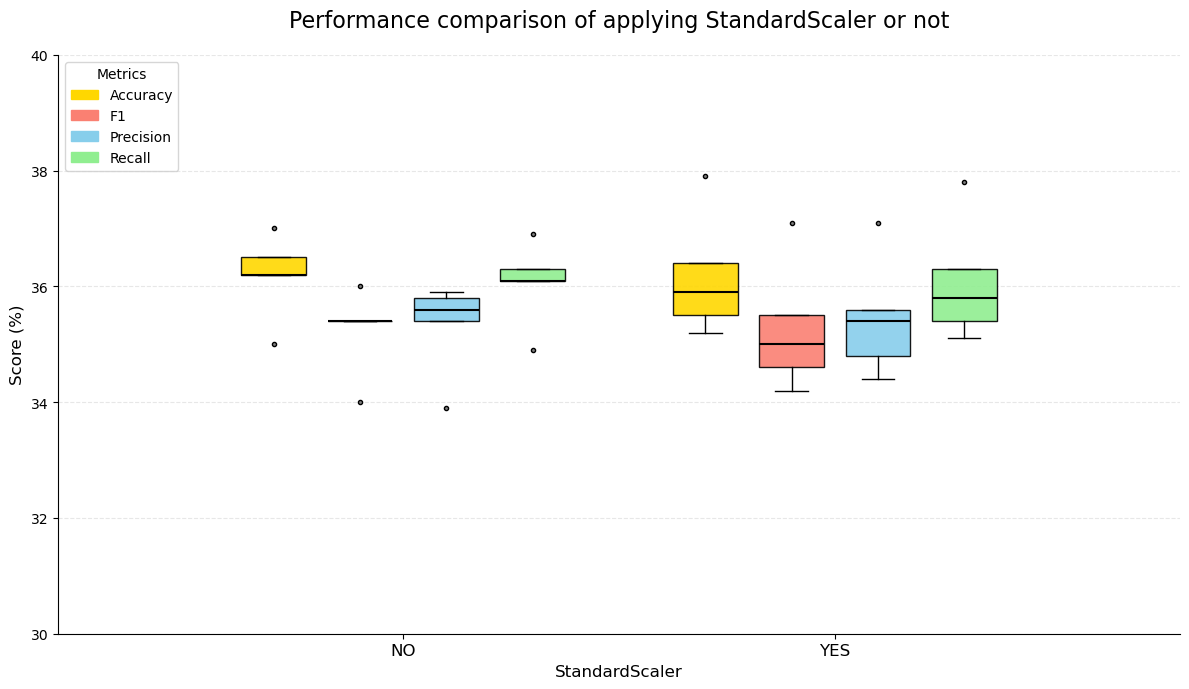

In [ ]:
performance_scaler = {
    'NO':[
        [36.2, 36.5, 35.0, 36.2, 37.0],
        [35.4, 35.4, 34.0, 35.4, 36.0],
        [35.6, 35.4, 33.9, 35.8, 35.9],
        [36.1, 36.3, 34.9, 36.1, 36.9]
    ],
    'YES':[
        [35.9, 36.4, 35.5, 35.2, 37.9],
        [35.0, 35.5, 34.6, 34.2, 37.1], 
        [35.4, 35.6, 34.8, 34.4, 37.1],
        [35.8, 36.3, 35.4, 35.1, 37.8]
    ]
}

plot_performance_boxplots(data=performance_scaler, 
                          title="Performance comparison between applying StandardScaler or not", 
                          dim=[30,40], 
                          x_axis_title="StandardScaler")

# DENSESIFT PARAMS EXPERIMENT

In [12]:
# List of [step_size, scale_size, [fold1_acc, fold2_acc, fold3_acc, fold4_acc, fold5_acc]]
dense_sift_params_results = [[8, 2, [0.3258620689655172, 0.34655172413793106, 0.3367816091954023, 0.335632183908046, 0.3350574712643678]], 
 [16, 2, [0.3103448275862069, 0.30977011494252876, 0.2982758620689655, 0.3005747126436782, 0.2850574712643678]], 
 [8, 4, [0.3505747126436782, 0.3603448275862069, 0.35977011494252875, 0.3482758620689655, 0.35574712643678164]], 
 [16, 4, [0.32988505747126434, 0.32241379310344825, 0.3264367816091954, 0.3425287356321839, 0.3235632183908046]], 
 [8, 8, [0.3568965517241379, 0.35919540229885055, 0.36379310344827587, 0.3735632183908046, 0.3511494252873563]], 
 [16, 8, [0.33793103448275863, 0.3442528735632184, 0.34195402298850575, 0.3471264367816092, 0.32471264367816094]], 
 [8, 16, [0.33620689655172414, 0.3425287356321839, 0.3505747126436782, 0.33793103448275863, 0.335632183908046]], 
 [16, 16, [0.3350574712643678, 0.3413793103448276, 0.3385057471264368, 0.35, 0.3350574712643678]], 
 [8, 32, [0.30344827586206896, 0.2925287356321839, 0.2925287356321839, 0.30114942528735633, 0.29310344827586204]], 
 [16, 32, [0.2913793103448276, 0.29310344827586204, 0.29310344827586204, 0.3114942528735632, 0.2896551724137931]]]

In [13]:
def plot_dense_sift_hyperparams(
    raw_data_list: List[Tuple[float, float, List[float]]]
):
    """
    Generates two plots (Heatmap and Line Plot) to compare Dense-SIFT
    performance across different Stride and Scale values using a list of tuples as input.

    Args:
        raw_data_list (List[Tuple[float, float, float]]): List of (stride, scale, mean_accuracy) tuples.
    """
    
    for i in range(len(raw_data_list)):
        stride, scale, accuracies = raw_data_list[i]
        acc_mean = np.mean(accuracies)*100
        raw_data_list[i] = (stride, scale, acc_mean)
        
    
    # 1. Convert the input list of tuples into a DataFrame
    df = pd.DataFrame(raw_data_list, columns=['stride', 'scale', 'acc_mean'])
    
    stride_vals = sorted(df['stride'].unique(), reverse=True)
    scale_vals = sorted(df['scale'].unique())
    
    # 2. Pivot the DataFrame to the required format (Stride as Index, Scale as Columns)
    pivot = df.pivot(index='stride', columns='scale', values='acc_mean')
    
    # 3. Re-index/re-column and sort to match desired plot order (Stride descending)
    # Using reindex and sorting to ensure consistency with axis labels
    pivot = pivot.loc[stride_vals].reindex(columns=scale_vals)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # ------------------------------
    #  PLOT 1 — HEATMAP
    # ------------------------------
    im = ax1.imshow(pivot, cmap="viridis", aspect="auto")

    # Annotate cells
    mean_val = pivot.values.mean()
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            # Use a threshold (mean) to decide text color for contrast
            text_color = "white" if val < mean_val else "black"
            ax1.text(
                j, i, f"{val:.1f}",
                ha="center", va="center",
                color=text_color, fontsize=10
            )

    # Axis labels + ticks
    ax1.set_title("Dense-SIFT Mean Accuracy (Stride vs Scale)", fontsize=14)
    ax1.set_xlabel("Scale", fontsize=12)
    ax1.set_ylabel("Stride", fontsize=12)
    
    # Set ticks using the ordered lists
    ax1.set_xticks(np.arange(len(scale_vals)))
    ax1.set_yticks(np.arange(len(stride_vals)))
    ax1.set_xticklabels(scale_vals, fontsize=10)
    ax1.set_yticklabels(stride_vals, fontsize=10)

    ax1.grid(True, linestyle="--", alpha=0.6, axis="both")

    fig.colorbar(im, ax=ax1, label="Accuracy (%)")

    # ------------------------------
    #  PLOT 2 — LINE PLOT
    # ------------------------------
    colors = plt.cm.viridis(np.linspace(0, 1, len(pivot.index)))

    for idx, stride_val in enumerate(pivot.index):
        ax2.plot(
            pivot.columns,
            pivot.loc[stride_val],
            marker="o",
            linewidth=2,
            color=colors[idx],
            label=f"Stride={int(stride_val)}",
        )

    ax2.set_title("Accuracy vs Scale for each Stride", fontsize=14)
    ax2.set_xlabel("Scale", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.grid(True, linestyle="--", alpha=0.6)
    ax2.tick_params(labelsize=10)
    ax2.legend(title="Stride", fontsize=10)

    plt.tight_layout()
    plt.show()

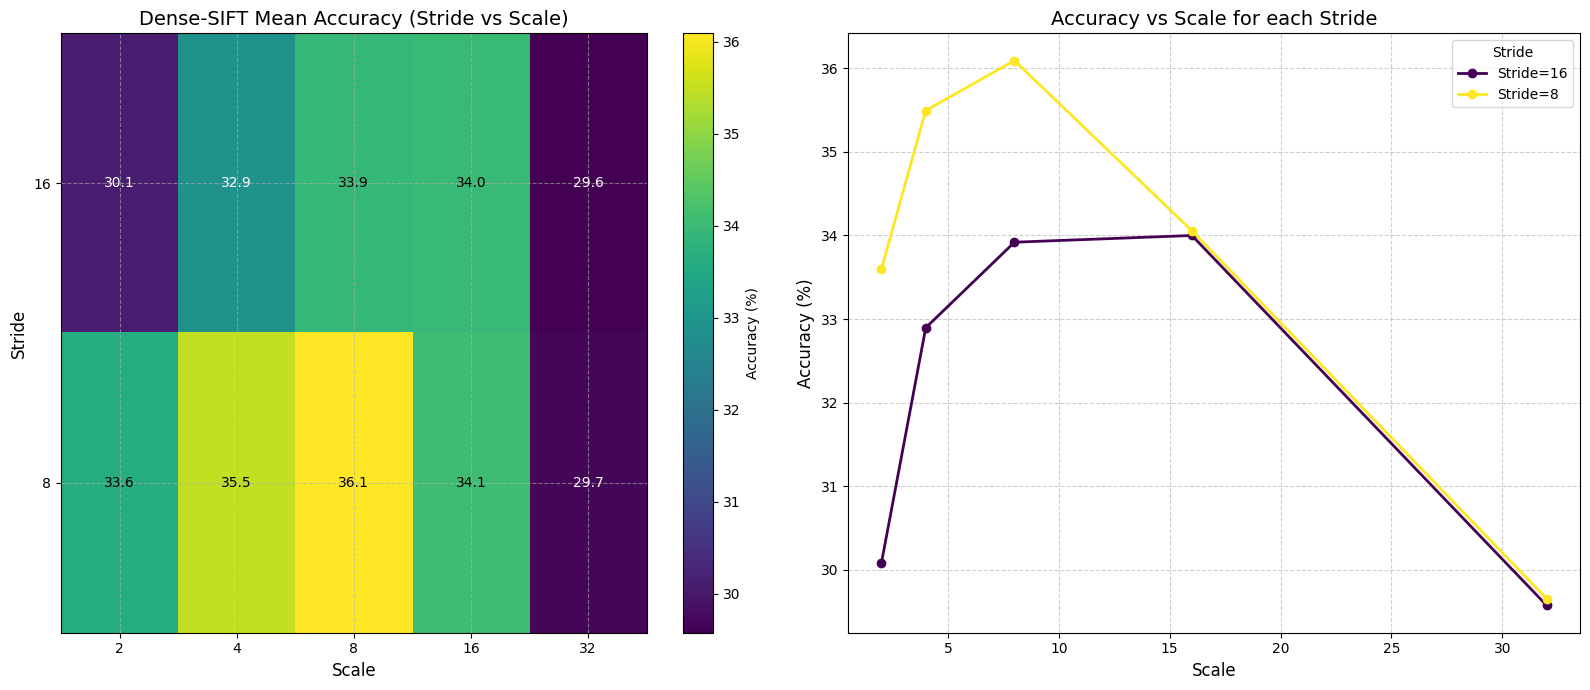

In [14]:
plot_dense_sift_hyperparams(raw_data_list=dense_sift_params_results)